In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
#CALIBRATION

cal = pd.read_csv("scope_0.csv", header=1)
cal.columns=["x-axis", "1", "2"]
R_ = np.average(cal["2"])/np.average(cal["1"]) * 11.99e3
Rp = R_ + 0.01e3
Rm = R_ - 0.01e3

K_ = -1/R_
Kp = -1/Rp
Km = -1/Rm

avg1 = np.average(cal["1"])
std1 = np.std(cal["1"])

avg2 = np.average(cal["2"])
std2 = np.std(cal["2"])

r1 = -std1/avg1
r2 = std2/avg2

print(std1, avg1, std2, avg2, r1, r2)

0.0005317143339957688 -0.02121608018875 0.011519530176253578 0.149959797409 0.025061855407094224 0.0768174562468582


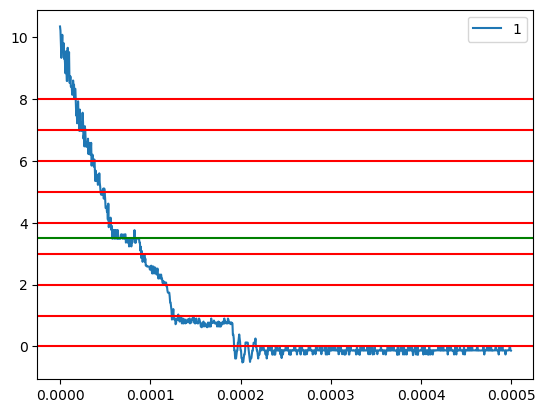

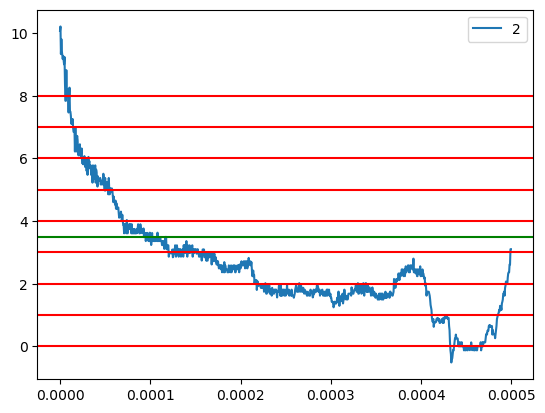

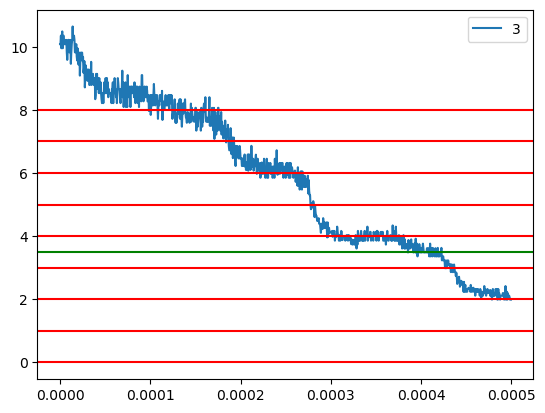

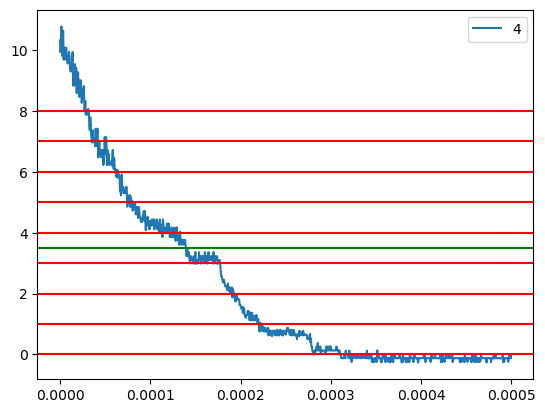

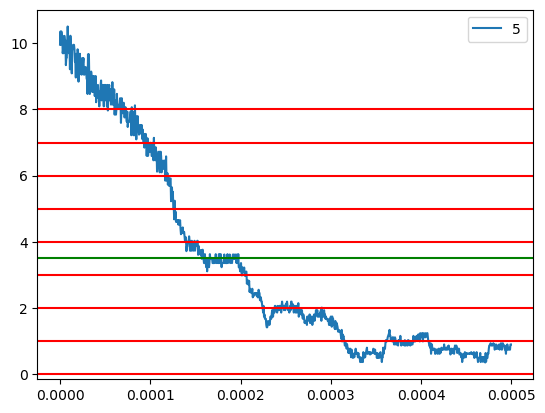

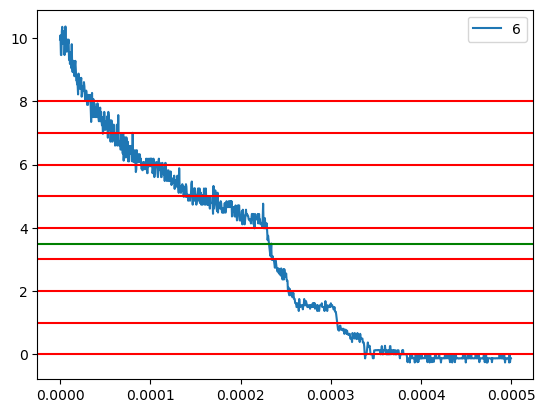

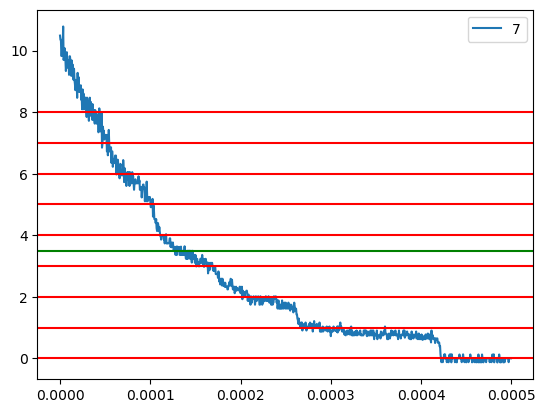

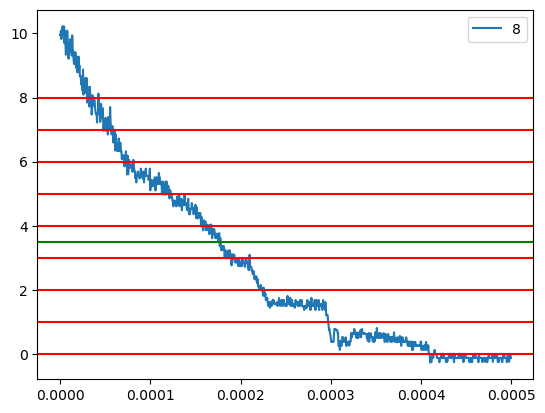

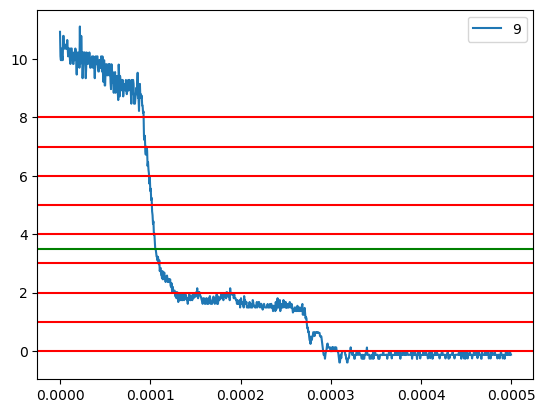

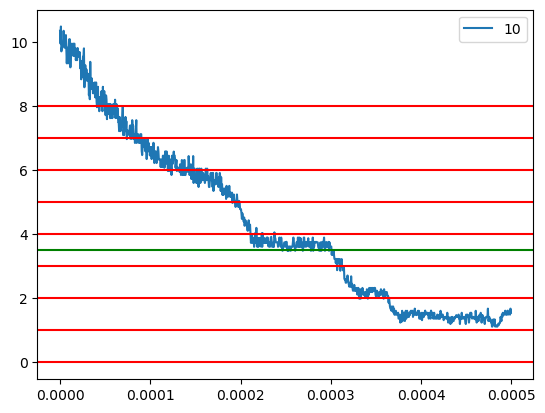

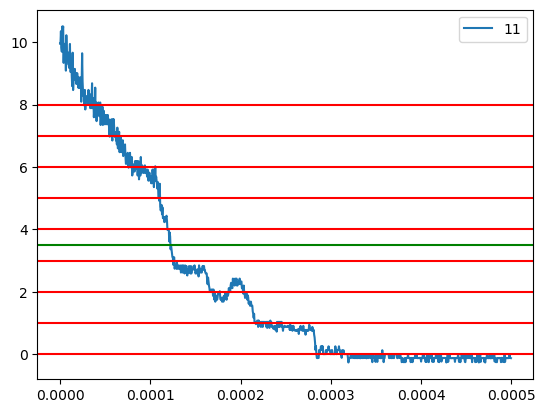

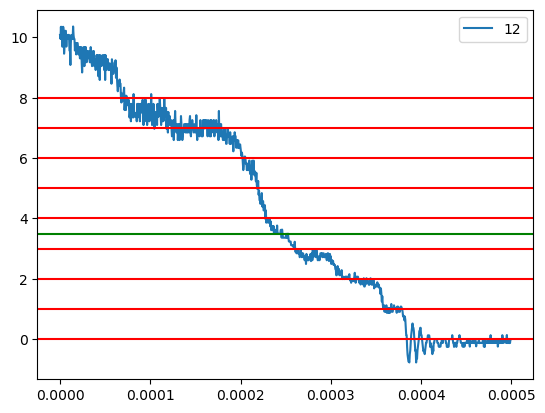

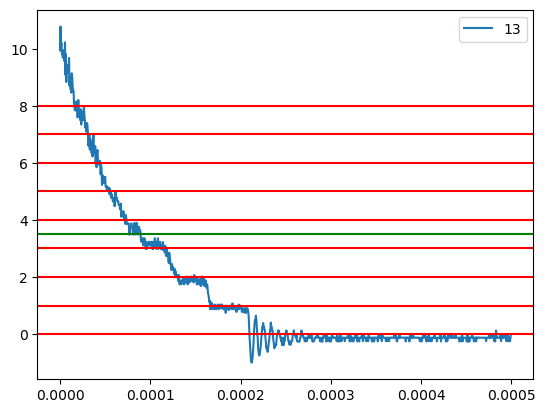

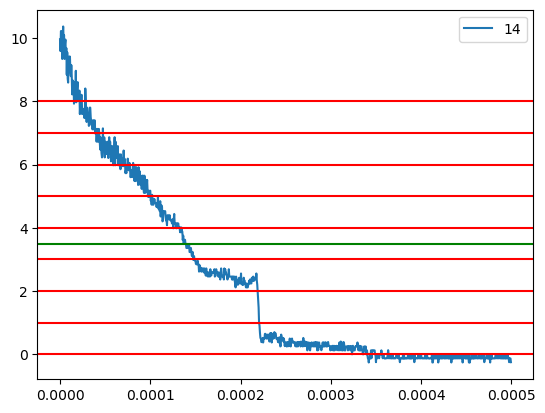

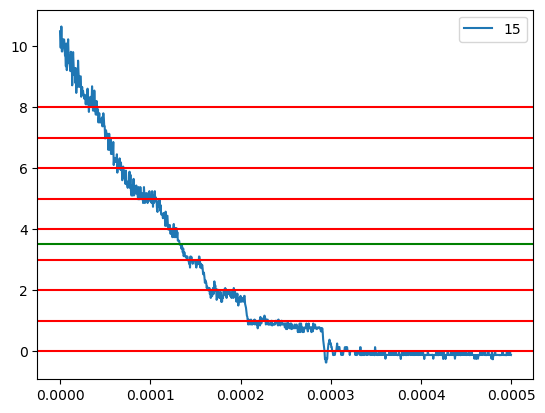

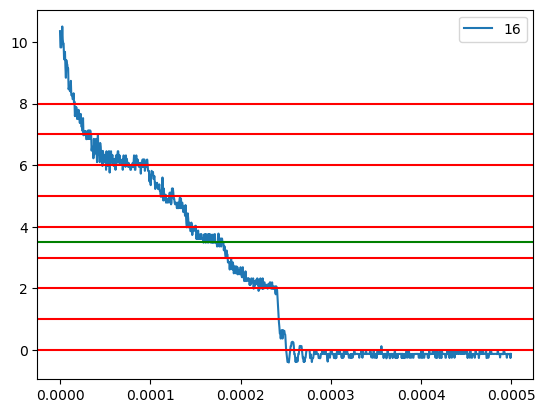

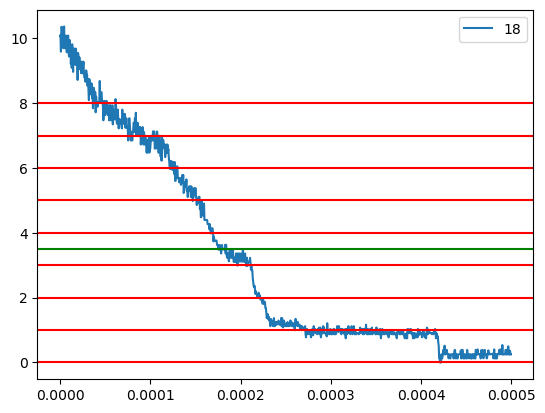

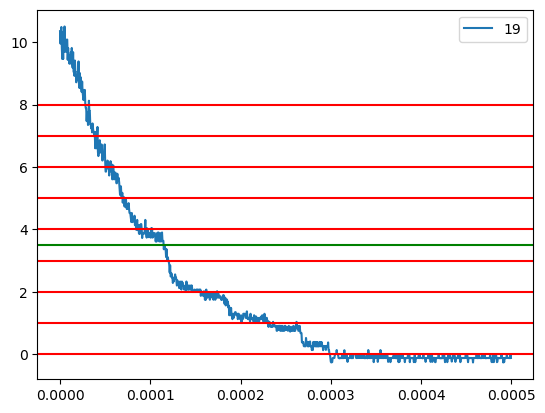

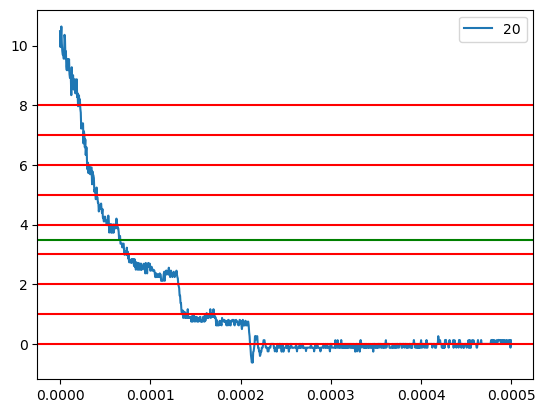

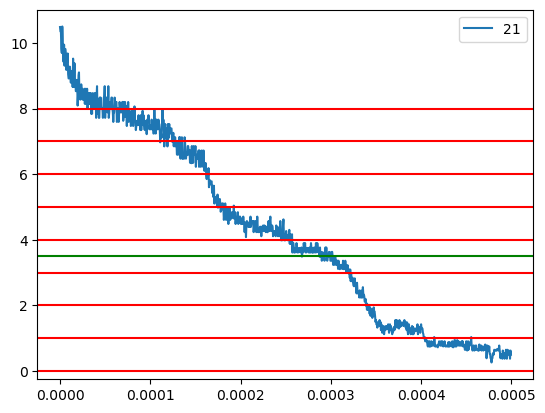

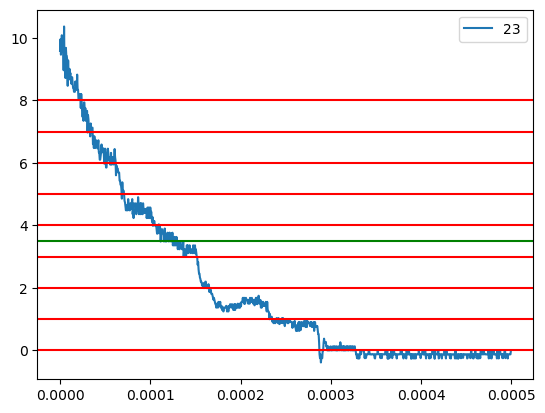

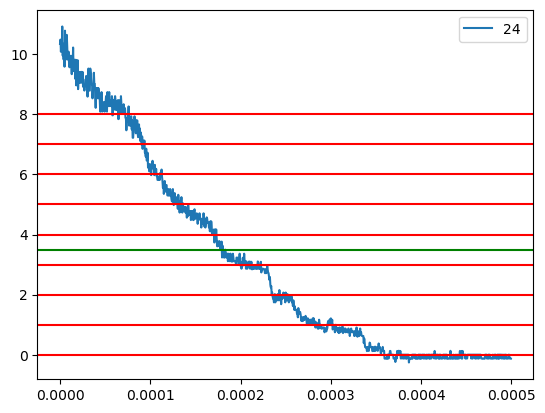

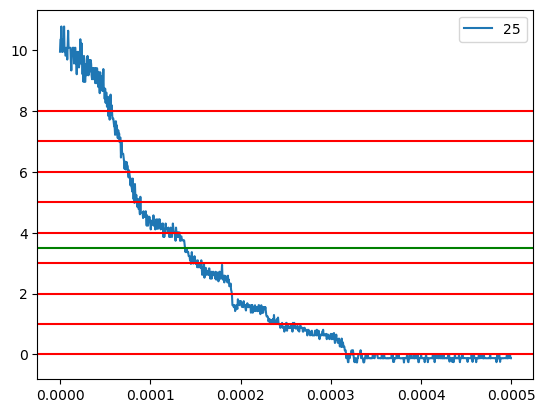

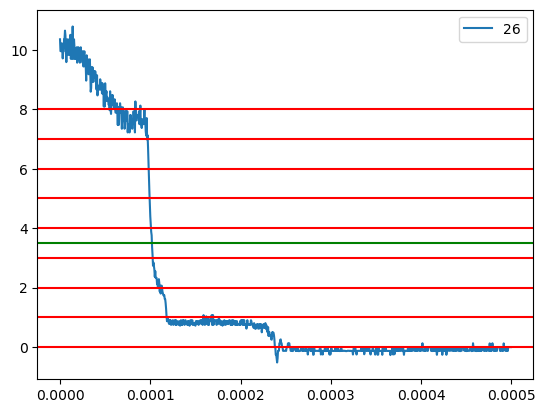

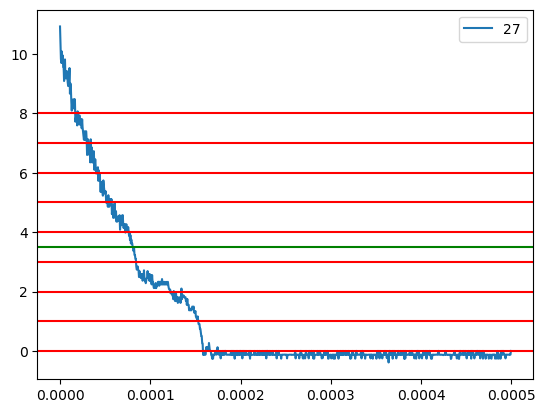

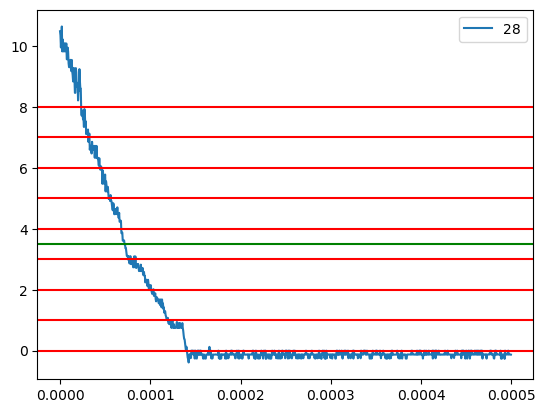

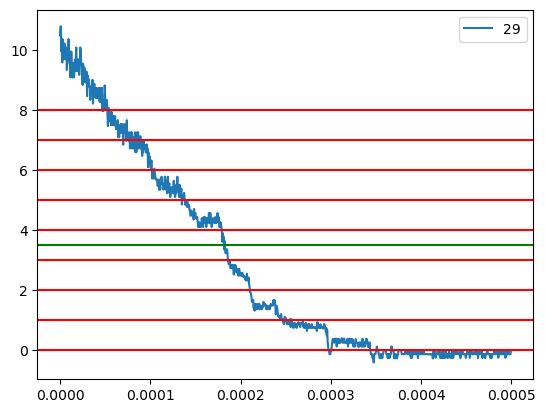

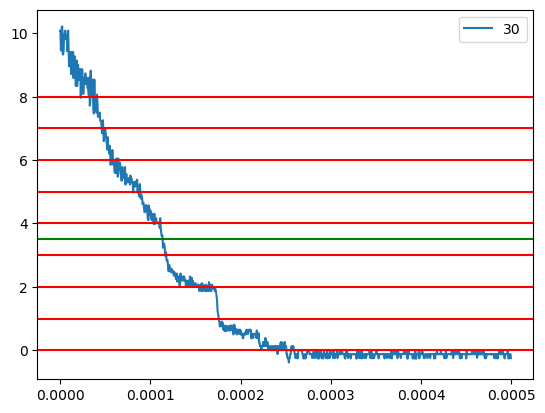

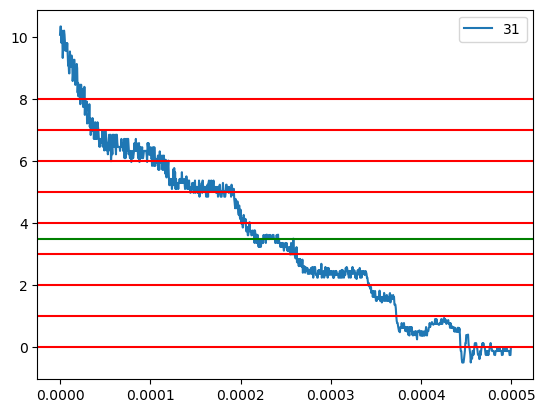

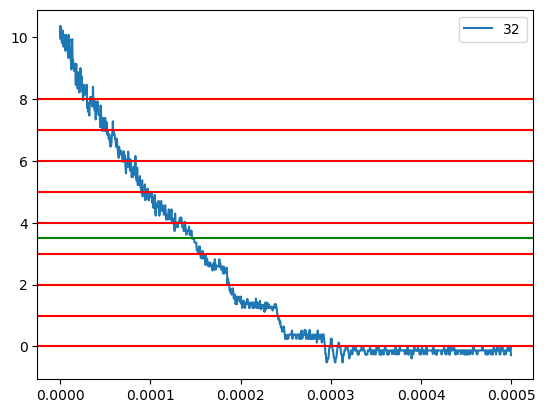

In [20]:
# conversion factor
k = 1/96000

e = 1.602176634e-19
h = 6.62607015e-34

G0 = 2*e**2/h

#[17,22, 2,5,6,8,9,12,14,20,21,23,25,27,28,29,32]

data = np.array([])
num = (num for num in range(1,33) if num not in [17,22])
# num=[9]
for i in num:
    ds = pd.read_csv(f"scope_{i}.csv", header=1)
    ds=ds[ds["second"] >= 0]
    ds.columns=["x-axis", "1", "2"]
    
    G = -k/G0 * ds["2"].astype(float)/ds["1"].astype(float)
    
    data = np.append(data, np.array(G))
    
    plt.plot(ds["x-axis"].astype(float), G, label=f"{i}")
    for g in range(9):
        plt.axhline(y=g, color="r")
    plt.axhline(y=3.5, color='g')
    plt.legend()
    plt.show()
    

[-2.14535493e+00 -3.70312465e+03  8.37853254e-01  9.55665958e+00
 -8.37040126e+00  7.59898665e+00  1.98361608e+02  4.99181789e-02
  3.21141247e+00  1.18266963e+04  2.22011417e+03  4.03651337e+01
  2.24528409e+03  9.16437482e+02 -1.50618539e+03] 
 [inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf]


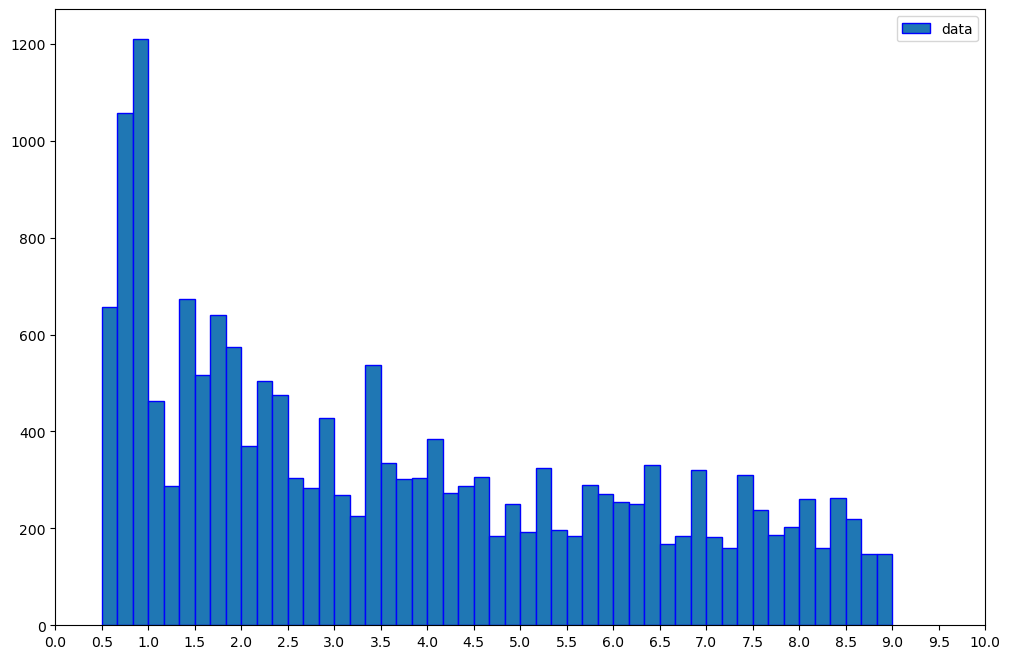

In [22]:
from scipy.optimize import curve_fit

def gauss(x,mu,sigma,A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def multimodal(x,mu1,mu2,mu3,mu4,mu5,sigma1,sigma2,sigma3,sigma4,sigma5,A1,A2,A3,A4,A5):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)+gauss(x,mu3,sigma3,A3)+gauss(x,mu4,sigma4,A4)+gauss(x,mu5,sigma5,A5)

fig = plt.figure(figsize=(12,8))

y,x,_= plt.hist(data, bins=51, range=[0.5, 9], edgecolor="b", label="data")
x = 0.5*(x[1:]+ x[:-1])

expected=(1,1,1,
          2,1,1,
          3,1,1,
          3.5,1,0.1,
          4,1,0.1)
params,cov=curve_fit(multimodal,x,y,expected, maxfev=200000)
sigma=np.sqrt(np.diag(cov))
print(params,'\n',sigma)

# plt.plot(x,multimodal(x,*params),color='red',lw=3,label='model')
plt.xticks(np.linspace(0,10,21))
plt.legend()
plt.show()

In [13]:
np.linspace(0.25,8.75,18)

array([0.25, 0.75, 1.25, 1.75, 2.25, 2.75, 3.25, 3.75, 4.25, 4.75, 5.25,
       5.75, 6.25, 6.75, 7.25, 7.75, 8.25, 8.75])

In [14]:
print(k, K_)
print(K_/k)

1.0416666666666666e-05 1.1799704191905344e-05
1.132771602422913


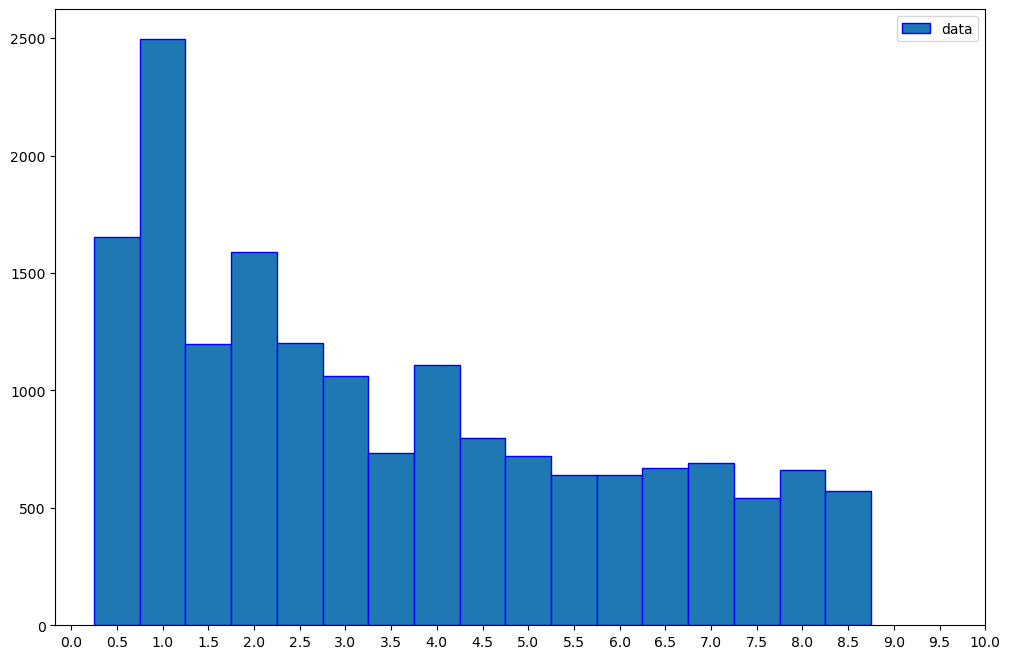

In [19]:
fig = plt.figure(figsize=(12,8))


plt.hist(data, bins=np.linspace(0.25,8.75,18), range=[0.25,8.75], edgecolor="b", label="data")
plt.xticks(np.linspace(0,10,21))
plt.legend()
plt.show()

In [31]:
print((Kp-Km)/2)
print(K_)

rel = (Kp-Km)/2 / K_ 
print(rel, r1, r2, np.sqrt(rel*rel+r1*r1+r2*r2), np.sqrt(rel*rel+2*r1*r1+2*r2*r2))

print(K_* np.sqrt(rel*rel+r1*r1+r2*r2))
K_

1.392330209550468e-09
1.1799704191905344e-05
0.00011799704356195756 0.025061855407094224 0.0768174562468582 0.0808024263496237 0.11427182629445648
9.534447289137777e-07


1.1799704191905344e-05